In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"ahmedmaherabdrabbo","key":"05d97c31da0fd77007416d36031d287c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


<br>

# Chest X-ray Pneumonia

<br>

## *1. Import Libraries*

In [ ]:
import os
import random

import cv2
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from glob import glob
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


import warnings
warnings.filterwarnings("ignore")

## *2. Load and Prepare Dataset*

In [ ]:
def images_to_dataframe(path, label):
    images = []
    for file in os.listdir(path):
        img_path = os.path.join(path, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img_resized = cv2.resize(img, (128, 128))
            images.append([img_resized, label])
    return pd.DataFrame(images, columns=['image', 'label'])

In [ ]:
data = {
    'normal_train': ['./chest_xray/train/NORMAL/', 0],
    'normal_test': ['./chest_xray/test/NORMAL/', 0],
    'pneumonia_train': ['./chest_xray/train/PNEUMONIA/', 1],
    'pneumonia_test': ['./chest_xray/test/PNEUMONIA/', 1]
}
df1 = images_to_dataframe(*data['normal_train'])
df2 = images_to_dataframe(*data['pneumonia_train'])
df3 = images_to_dataframe(*data['normal_test'])
df4 = images_to_dataframe(*data['pneumonia_test'])

df_all = pd.concat([df1, df2, df3, df4], ignore_index=True)

df_train, df_test = train_test_split(df_all, test_size=0.2, stratify=df_all['label'], random_state=42)

df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)


## *3. Exploratory Data Analysis (EDA)*

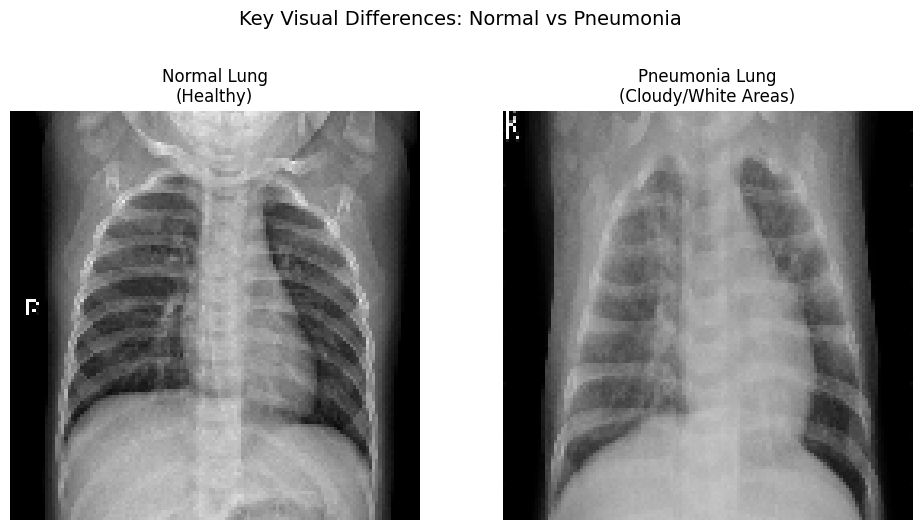

In [ ]:
normal_img = df_train[df_train['label']==0]['image'].iloc[0]
pneumonia_img = df_train[df_train['label']==1]['image'].iloc[0]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(normal_img, cmap='gray')
plt.title('Normal Lung\n(Healthy)', fontsize=12)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pneumonia_img, cmap='gray')
plt.title('Pneumonia Lung\n(Cloudy/White Areas)', fontsize=12)
plt.axis('off')

plt.suptitle('Key Visual Differences: Normal vs Pneumonia', y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

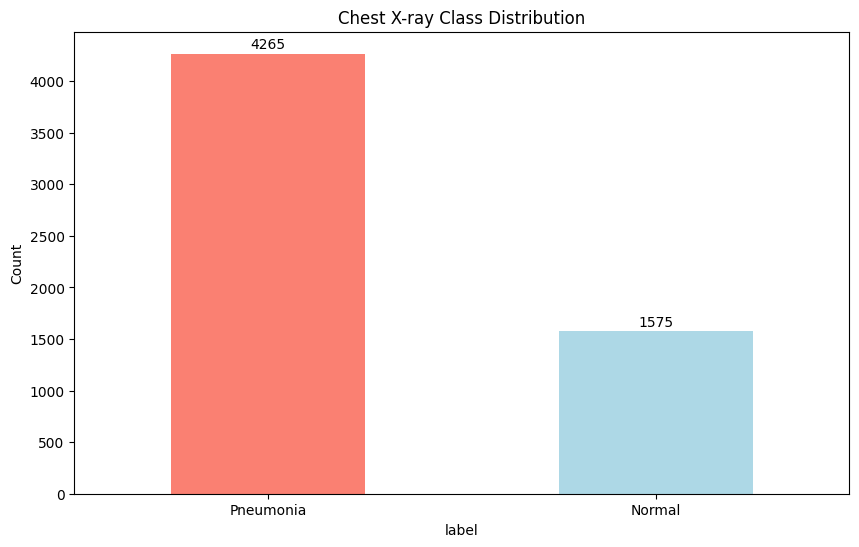

In [ ]:
# Class distribution bar plot
plt.figure(figsize=(10, 6))

df_all['label'].value_counts(ascending=False).plot(kind='bar', color=['salmon', 'lightblue'])

plt.title('Chest X-ray Class Distribution', fontsize=12)
plt.xticks([0, 1], ['Pneumonia', 'Normal'], rotation=0)
plt.ylabel('Count')

for i, count in enumerate(df_all['label'].value_counts(ascending=False)):
    plt.text(i, count + 20, str(count), ha='center', va='bottom', fontsize=10)

plt.show()


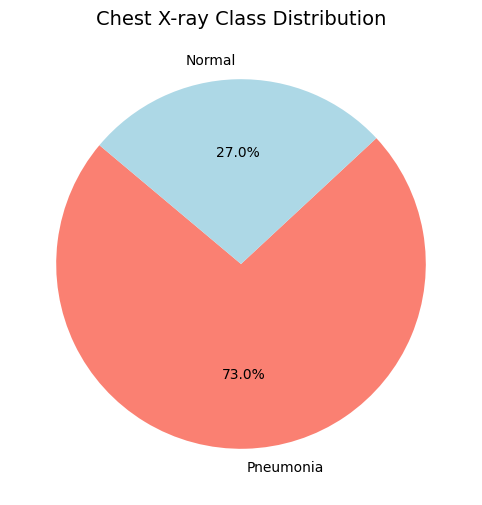

In [ ]:
# Pie chart
label_counts = df_all['label'].value_counts()
plt.figure(figsize=(10, 6))

plt.pie(
    label_counts,
    labels=['Pneumonia', 'Normal'],
    autopct='%1.1f%%',
    startangle=140,
    colors=['salmon', 'lightblue'],
    wedgeprops={'linewidth': 1, 'linestyle': 'solid'}
)

plt.title('Chest X-ray Class Distribution', fontsize=14)

plt.show()


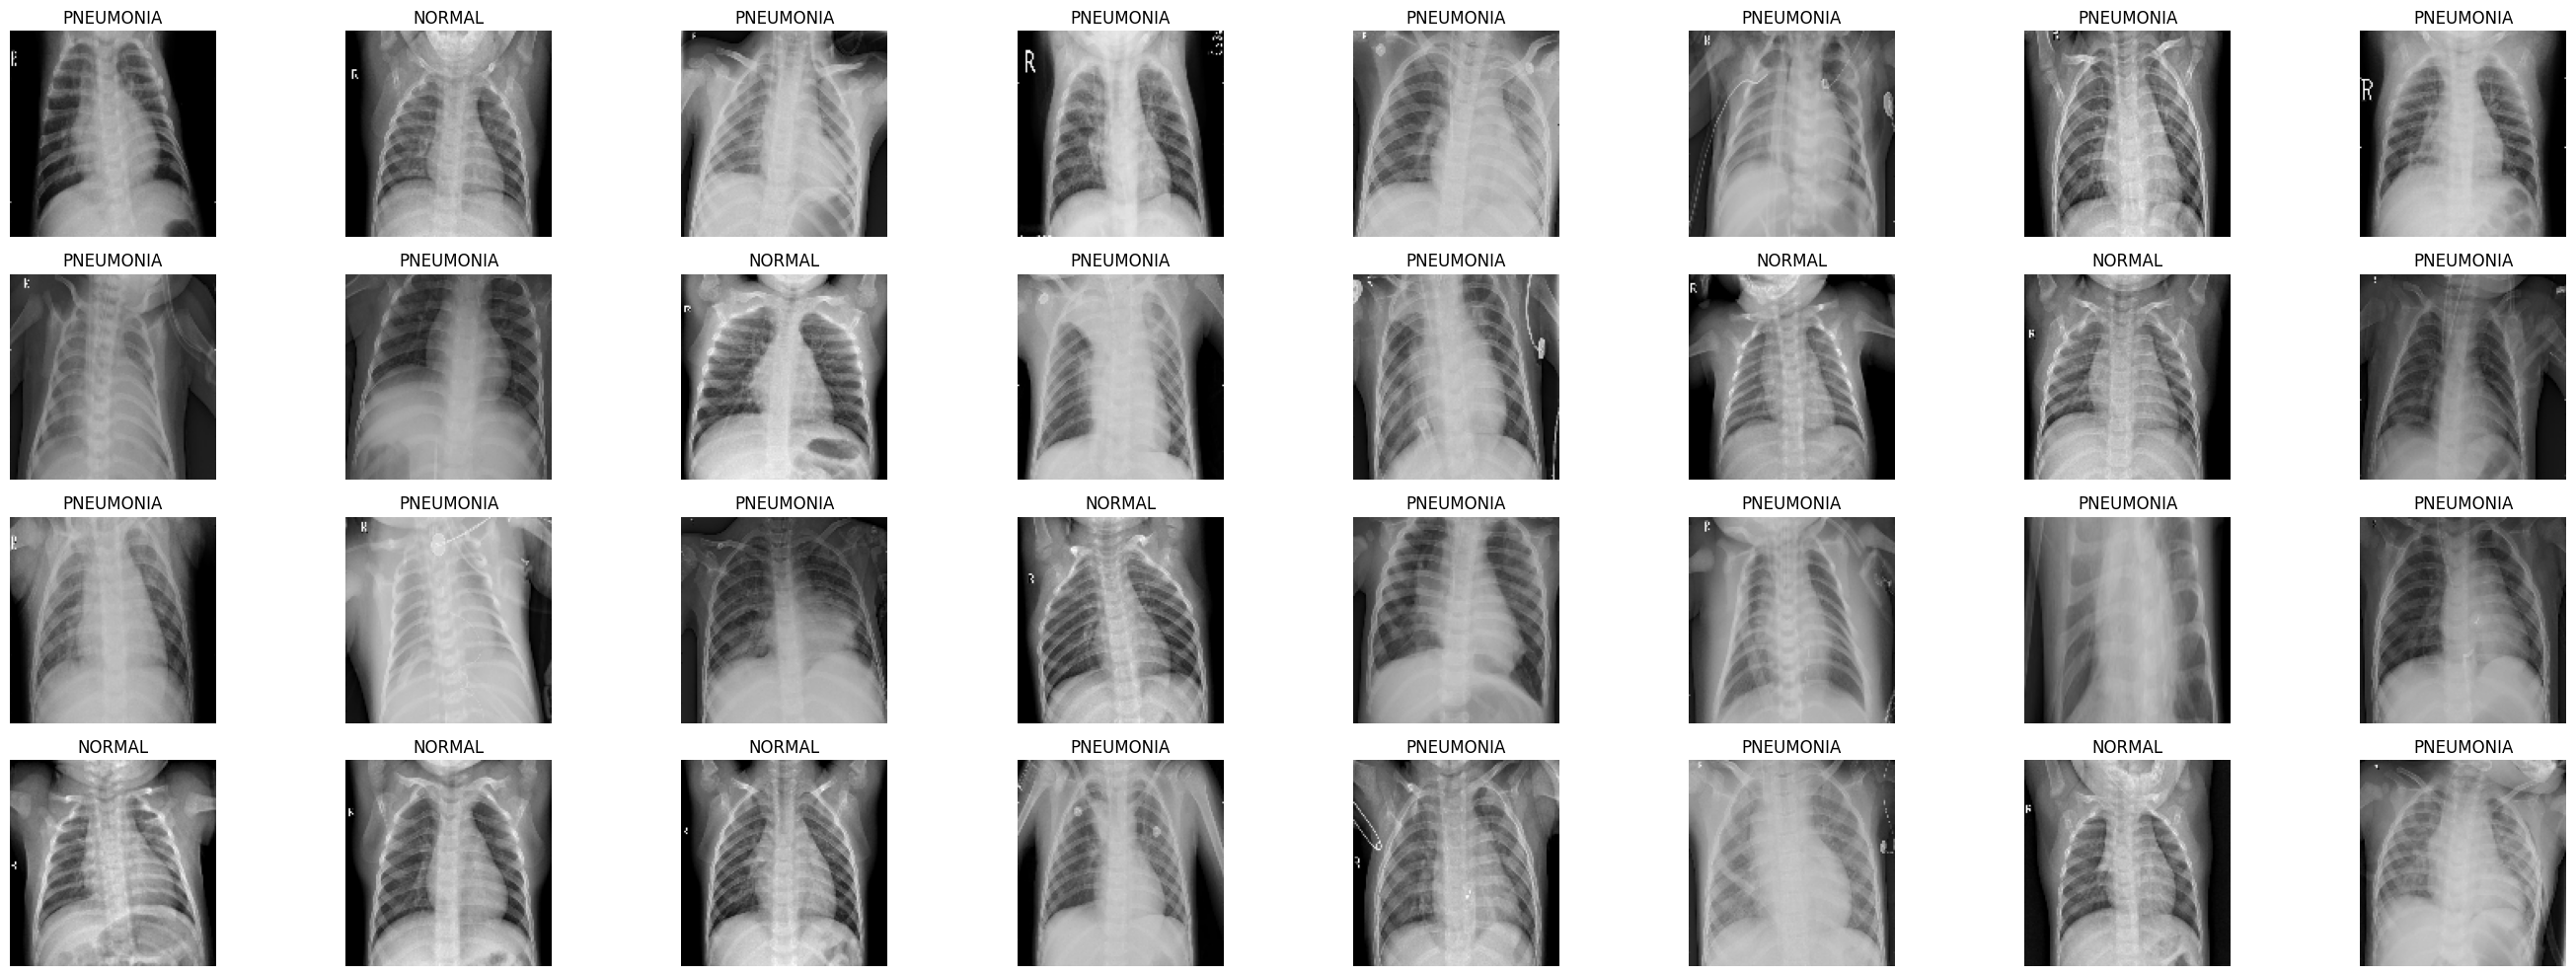

In [ ]:
# Sample images visualization
norm_path = '/content/chest_xray/train/NORMAL'
pneumonia_path = '/content/chest_xray/train/PNEUMONIA'

norm_imgs = [f for f in os.listdir(norm_path) if f.endswith(('.jpeg', '.jpg', '.png'))]
pneumonia_imgs = [f for f in os.listdir(pneumonia_path) if f.endswith(('.jpeg', '.jpg', '.png'))]

all_imgs = [norm_path + '/' + i for i in norm_imgs] + [pneumonia_path + '/' + j for j in pneumonia_imgs]
random.shuffle(all_imgs)

IMAGE_SIZE = (128, 128)

plt.figure(figsize=(28, 10))
for counter, img_path in enumerate(all_imgs[:32]):
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMAGE_SIZE)
    label = img_path.split('/')[-2]

    plt.subplot(4, 8, counter + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()


<Figure size 800x400 with 0 Axes>

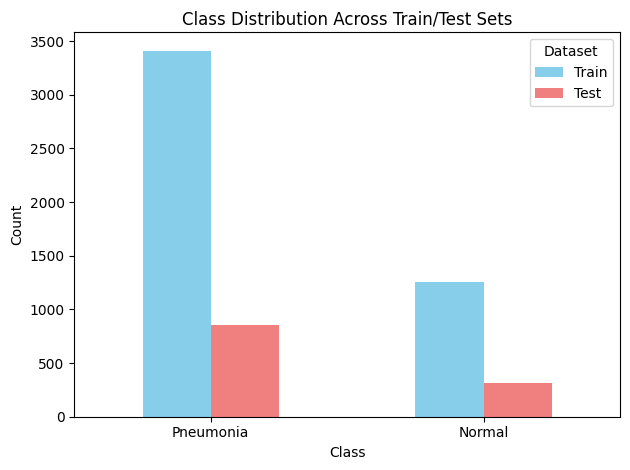

In [ ]:
class_dist_df = pd.DataFrame({
    'Train': df_train['label'].value_counts(),
    'Test': df_test['label'].value_counts()
}).loc[[1, 0]]

plt.figure(figsize=(8,4))
class_dist_df.plot(kind='bar', color=['skyblue','lightcoral'])

plt.title('Class Distribution Across Train/Test Sets')
plt.xticks([0,1], ['Pneumonia','Normal'], rotation=0)
plt.ylabel('Count')
plt.xlabel('Class')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()


## *4. Feature Extraction (HOG + Flattened Pixels)*

In [ ]:
def extract_combined_features(df):
    features = []
    for img in df['image']:
        hog_feat = hog(img, orientations=9, pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=False)
        flat_feat = img.flatten()
        combined = np.concatenate((hog_feat, flat_feat))
        features.append(combined)
    return np.array(features), df['label'].values


In [ ]:
X_train_combined, y_train = extract_combined_features(df_train)
X_test_combined, y_test = extract_combined_features(df_test)

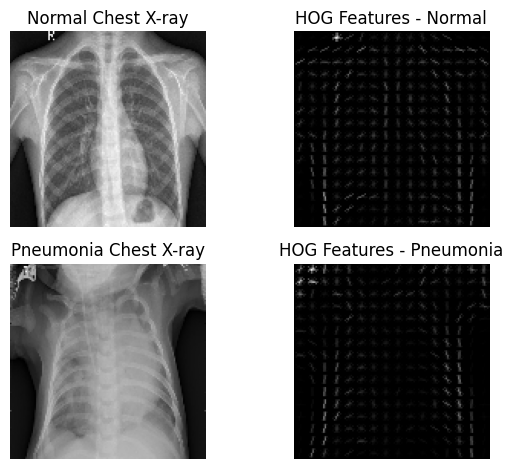

In [ ]:
# HOG visualization for Normal vs. Pneumonia

norm_img_path = '/content/chest_xray/chest_xray/test/NORMAL/IM-0001-0001.jpeg'
pneumonia_img_path = '/content/chest_xray/chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg'

norm_img = cv2.imread(norm_img_path, cv2.IMREAD_GRAYSCALE)
pneumonia_img = cv2.imread(pneumonia_img_path, cv2.IMREAD_GRAYSCALE)

norm_img = cv2.resize(norm_img, (128, 128))
pneumonia_img = cv2.resize(pneumonia_img, (128, 128))

plt.subplot(2, 2, 1)
plt.imshow(norm_img, cmap='gray')
plt.title('Normal Chest X-ray')
plt.axis('off')

features_norm, hog_norm = hog(norm_img, orientations=9, pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')
plt.subplot(2, 2, 2)
plt.imshow(hog_norm, cmap='gray')
plt.title('HOG Features - Normal')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(pneumonia_img, cmap='gray')
plt.title('Pneumonia Chest X-ray')
plt.axis('off')

features_pneumonia, hog_pneumonia = hog(pneumonia_img, orientations=9, pixels_per_cell=(8, 8),
                                      cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')
plt.subplot(2, 2, 4)
plt.imshow(hog_pneumonia, cmap='gray')
plt.title('HOG Features - Pneumonia')
plt.axis('off')



plt.tight_layout()
plt.show()


## *5. Preprocessing (Scaling, PCA, Feature Selection, SMOTE)*

In [ ]:
# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_combined)

In [ ]:
# Dimensionality reduction (PCA)
pca = PCA(n_components=100 , random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
# Feature selection
selector = SelectKBest(score_func=mutual_info_classif, k=100)
X_train_selected = selector.fit_transform(X_train_pca, y_train)
X_test_selected = selector.transform(X_test_pca)

In [ ]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)

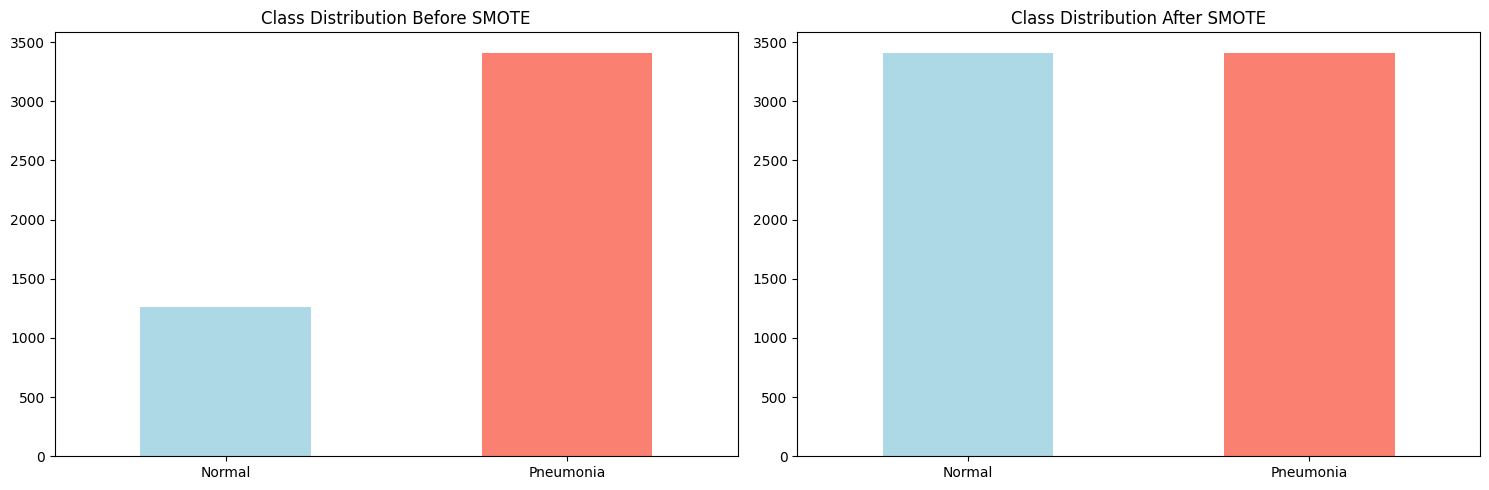

In [ ]:
# Plot class distribution before/after SMOTE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Before SMOTE
pd.Series(y_train).value_counts().sort_index().plot(kind='bar', ax=ax1, color=['lightblue', 'salmon'])
ax1.set_title('Class Distribution Before SMOTE')
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Normal', 'Pneumonia'], rotation=0)

# After SMOTE
pd.Series(y_train_balanced).value_counts().sort_index().plot(kind='bar', ax=ax2, color=['lightblue', 'salmon'])
ax2.set_title('Class Distribution After SMOTE')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Normal', 'Pneumonia'], rotation=0)

plt.tight_layout()
plt.show()


## *6. Model Training & Evaluation*

In [ ]:
# Define models
models = {
    'KNN': KNeighborsClassifier(n_neighbors=10),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    'SVM': SVC(kernel='rbf', C=1, gamma='scale', random_state=42, probability=True),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=300, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [ ]:
# Train and evaluate
results = []

for name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test_selected)
    acc = accuracy_score(y_test, y_pred)
    results.append({'Model': name, 'Accuracy': acc})

results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

print("Models Accuracy")
print(results_df)


Models Accuracy
                 Model  Accuracy
0  Logistic Regression  0.958904
1                  SVM  0.954623
2              XGBoost  0.939212
3        Random Forest  0.938356
4        Decision Tree  0.889555
5                  KNN  0.886986
6          Naive Bayes  0.774829


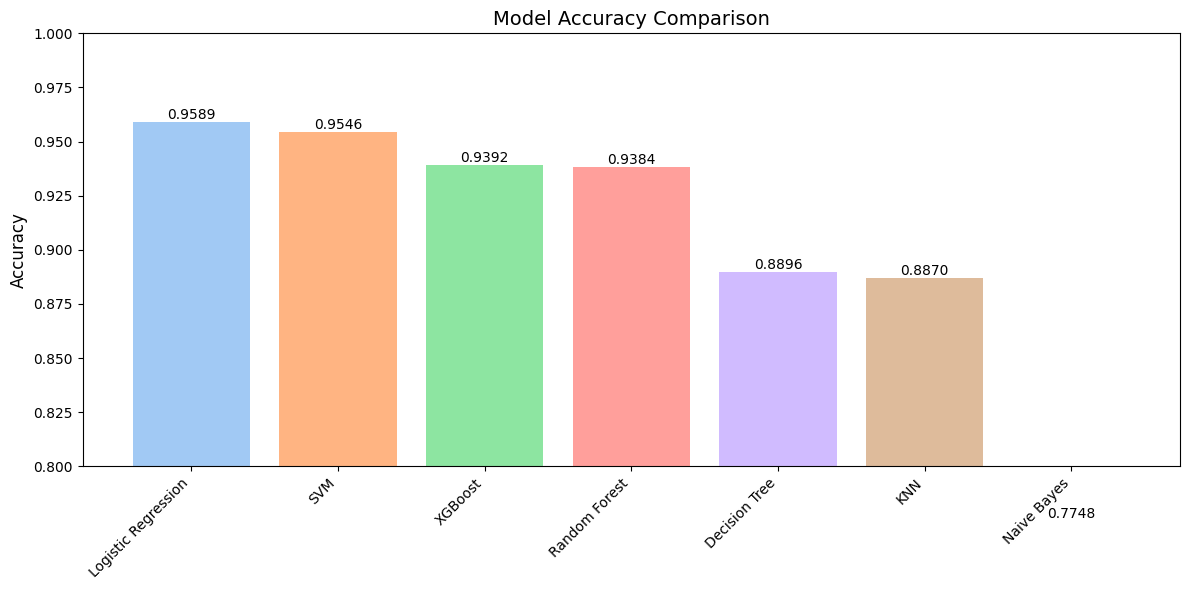

In [ ]:
# Plot accuracy comparison
plt.figure(figsize=(12, 6))

colors = ['#a1c9f4', '#ffb482', '#8de5a1', '#ff9f9b', '#d0bbff', '#debb9b', '#fab0e4']

bars = plt.bar(results_df['Model'], results_df['Accuracy'], color=colors)

plt.title('Model Accuracy Comparison', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0.8, 1.0)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()


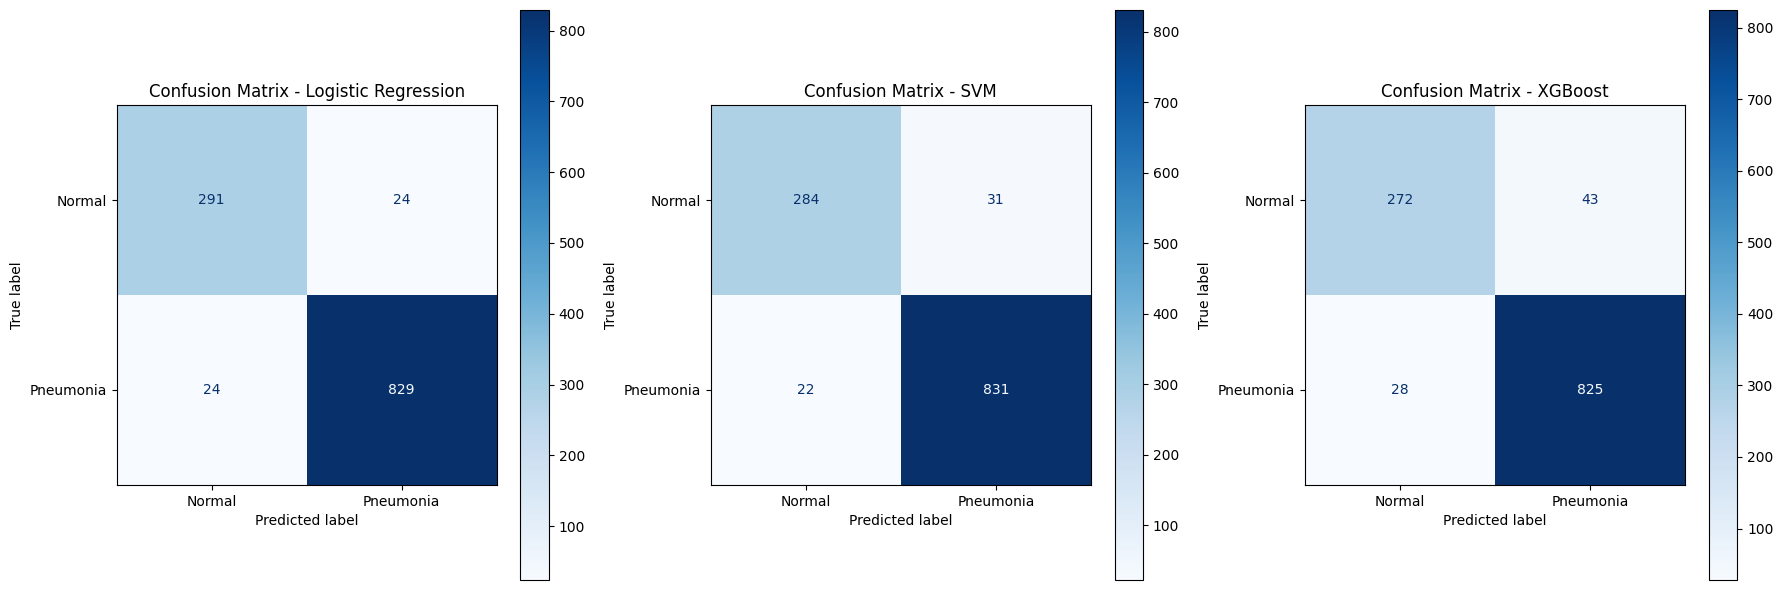

In [ ]:
# Confusion matrices for top 3 models
top3_models_names = results_df['Model'][:3].values

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, name in enumerate(top3_models_names):
    model = models[name]
    y_pred_best = model.predict(X_test_selected)
    cm = confusion_matrix(y_test, y_pred_best)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])

    ax = axes[i]
    disp.plot(cmap='Blues', ax=ax)
    ax.set_title(f"Confusion Matrix - {name}")

plt.tight_layout()
plt.show()


## *7. Ensemble Methods (Voting, Bagging, Stacking)*

*Voting* Classifier

In [ ]:
# Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('logreg', LogisticRegression(max_iter=1000 , random_state=42)),
    ('svm', SVC(kernel='rbf', C=1, gamma='scale')),
    ('xgb', XGBClassifier(n_estimators=300, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss', random_state=42))
], voting='hard')

voting_clf.fit(X_train_balanced, y_train_balanced)

y_pred_voting = voting_clf.predict(X_test_selected)
acc_voting = accuracy_score(y_test, y_pred_voting)
print(f"Voting Classifier Accuracy: {acc_voting:.4f}")

Voting Classifier Accuracy: 0.9563


**Bagging** Classifier

In [ ]:
# Bagging Classifier
bagging_clf = BaggingClassifier(LogisticRegression(max_iter=1000, random_state=42), n_estimators=10,random_state=42)

bagging_clf.fit(X_train_balanced, y_train_balanced)

y_pred_bagging = bagging_clf.predict(X_test_selected)
acc_bagging = accuracy_score(y_test, y_pred_bagging)
print(f"Bagging Classifier Accuracy: {acc_bagging:.4f}")


Bagging Classifier Accuracy: 0.9555


Stacking

In [ ]:
# Stacking Classifier
estimators = [
    ('logreg', LogisticRegression(max_iter=1000, random_state=42)),
    ('svm', SVC(kernel='rbf', C=1, gamma='scale')),
    ('xgb', XGBClassifier(n_estimators=300, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss', random_state=42))
]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=42))

stacking_clf.fit(X_train_balanced, y_train_balanced)

y_pred_stacking = stacking_clf.predict(X_test_selected)
acc_stacking = accuracy_score(y_test, y_pred_stacking)
print(f"Stacking Classifier Accuracy: {acc_stacking:.4f}")

Stacking Classifier Accuracy: 0.9512


## *8. Results Analysis*

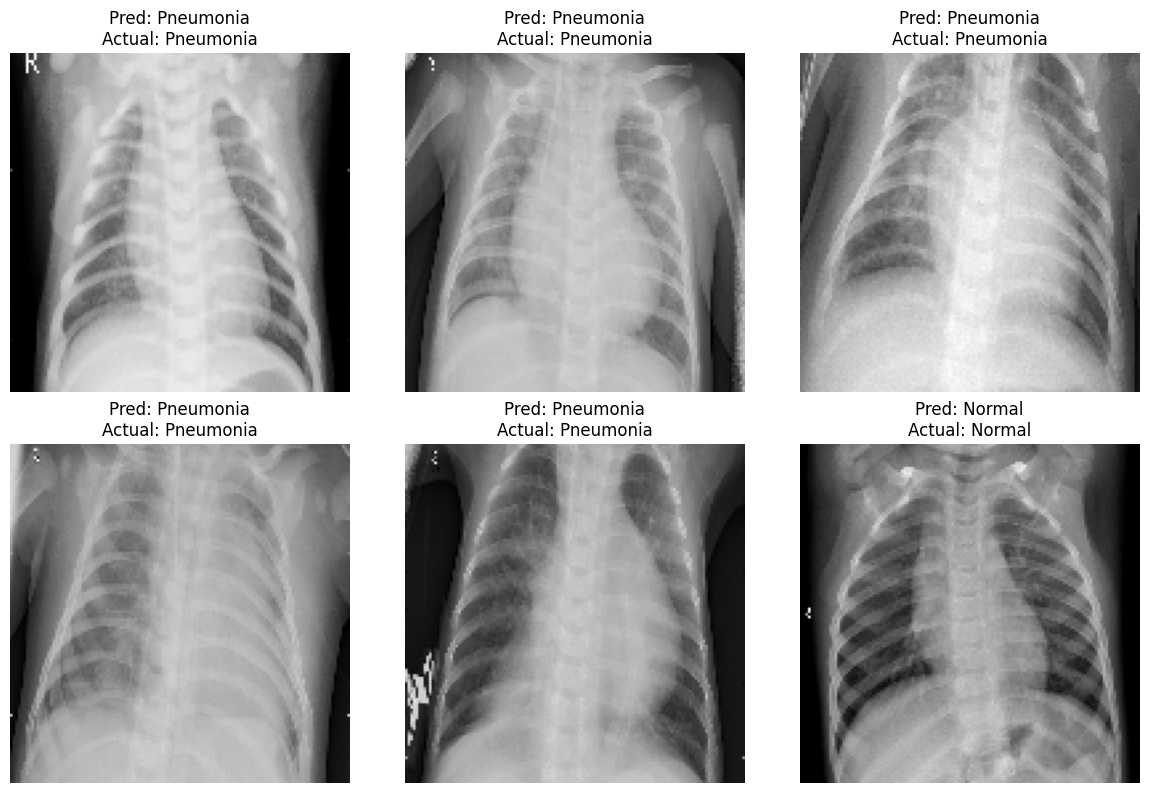

Classification Report:
               precision    recall  f1-score      support
Normal         0.928571  0.907937  0.918138   315.000000
Pneumonia      0.966279  0.974209  0.970228   853.000000
accuracy       0.956336  0.956336  0.956336     0.956336
macro avg      0.947425  0.941073  0.944183  1168.000000
weighted avg   0.956110  0.956336  0.956180  1168.000000


In [ ]:
# Correctly classified examples
y_pred = voting_clf.predict(X_test_selected)

correctly_classified_indices = np.where(y_pred == y_test)[0]

label_mapping = {0: 'Normal', 1: 'Pneumonia'}

plt.figure(figsize=(12, 8))
for i, idx in enumerate(correctly_classified_indices[:6]):
    plt.subplot(2, 3, i + 1)
    img = df_test.iloc[idx]['image']
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {label_mapping[y_pred[idx]]}\nActual: {label_mapping[y_test[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

report = classification_report(y_test, y_pred, target_names=['Normal', 'Pneumonia'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

print("Classification Report:\n", report_df)


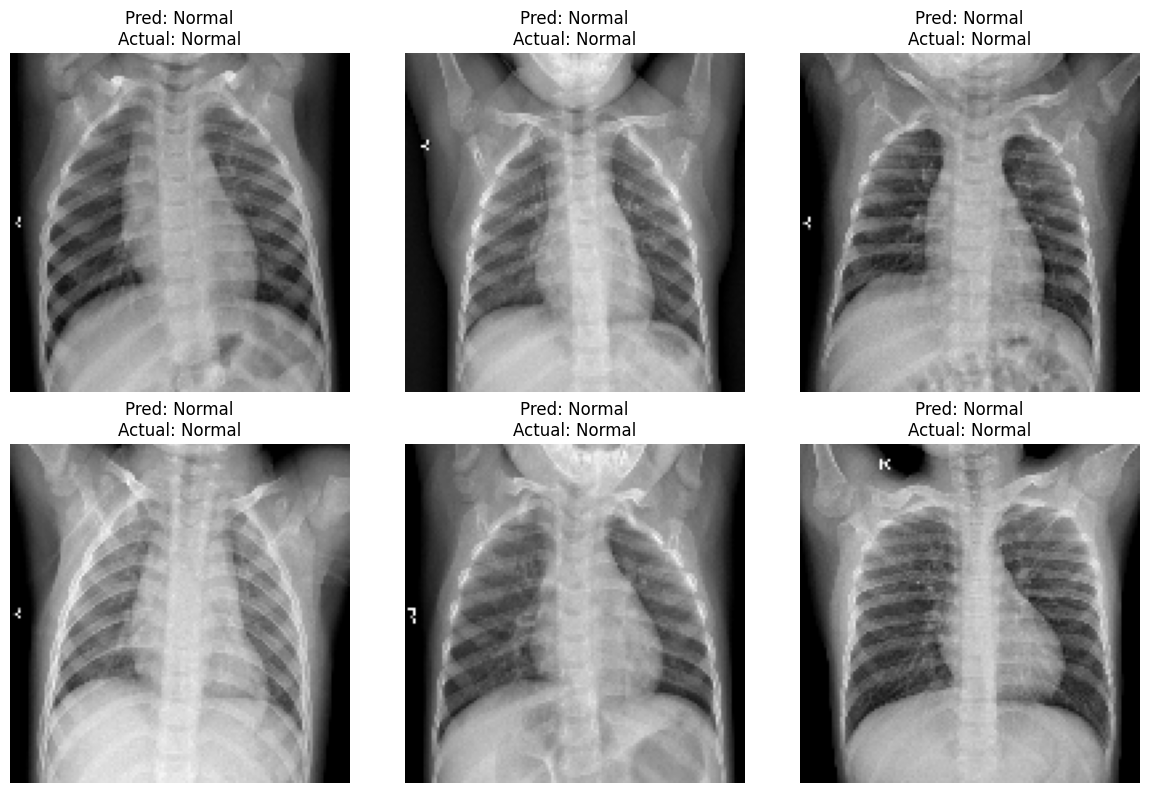

In [ ]:
y_pred = voting_clf.predict(X_test_selected)

correctly_classified_normal_indices = np.where((y_pred == y_test) & (y_test == 0))[0]

label_mapping = {0: 'Normal', 1: 'Pneumonia'}

plt.figure(figsize=(12, 8))
for i, idx in enumerate(correctly_classified_normal_indices[:6]):
    plt.subplot(2, 3, i + 1)
    img = df_test.iloc[idx]['image']
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {label_mapping[y_pred[idx]]}\nActual: {label_mapping[y_test[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()



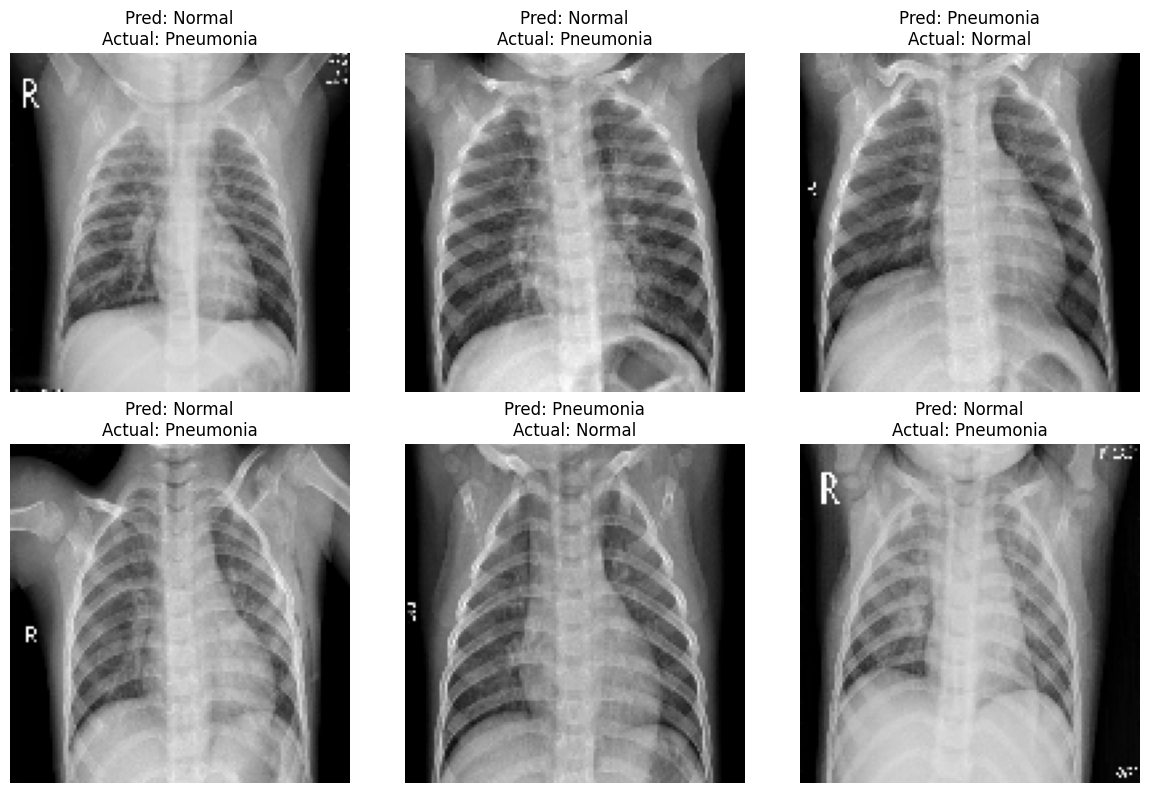

In [ ]:
y_pred = voting_clf.predict(X_test_selected)

misclassified_indices = np.where(y_pred != y_test)[0]

label_mapping = {0: 'Normal', 1: 'Pneumonia'}

plt.figure(figsize=(12, 8))
for i, idx in enumerate(misclassified_indices[:6]):
    plt.subplot(2, 3, i + 1)
    img = df_test.iloc[idx]['image']
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {label_mapping[y_pred[idx]]}\nActual: {label_mapping[y_test[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()



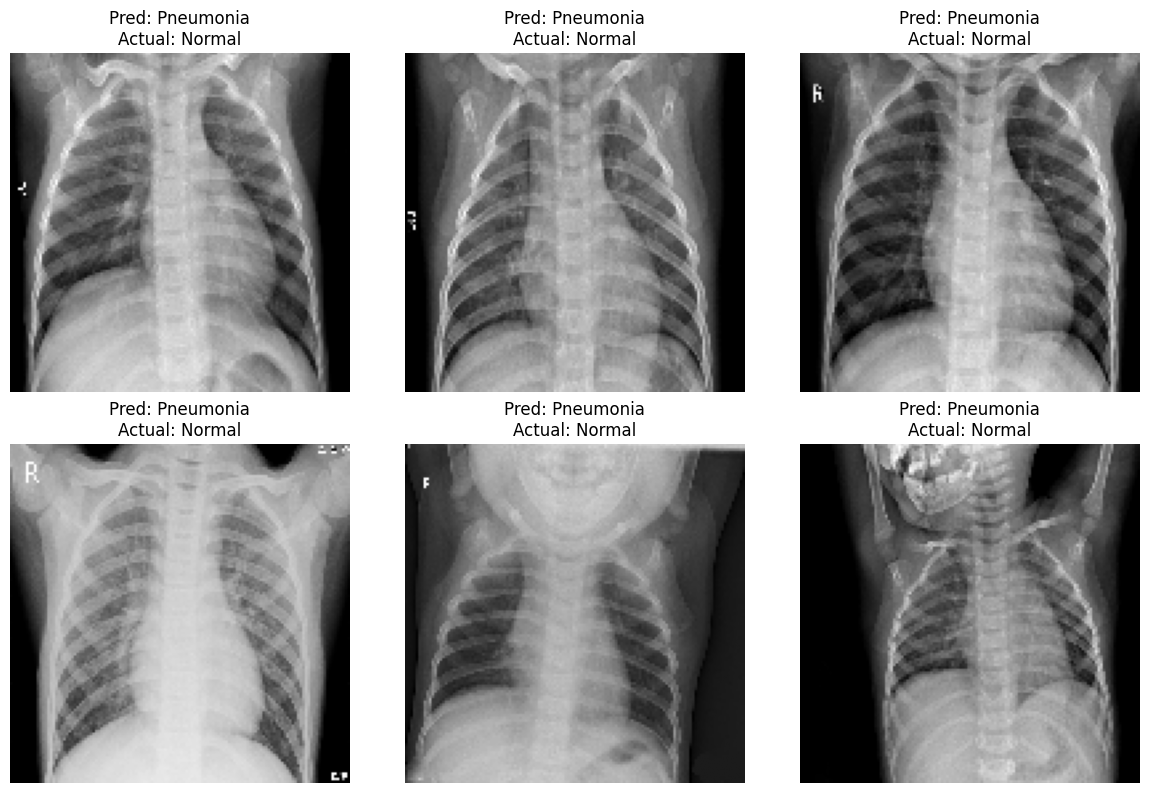

In [ ]:
misclassified_indices = np.where((y_pred != y_test) & (y_test == 0) & (y_pred == 1))[0]

label_mapping = {0: 'Normal', 1: 'Pneumonia'}

plt.figure(figsize=(12, 8))
for i, idx in enumerate(misclassified_indices[:6]):
    plt.subplot(2, 3, i + 1)
    img = df_test.iloc[idx]['image']
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {label_mapping[y_pred[idx]]}\nActual: {label_mapping[y_test[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
